# <center> Fruit Identification using a CNN  </center> <br> 
### <center> Keras/TensorFow </center><br> 
<center> Dr.-Ing. Daniel Lachner-Piza </center>
<center> AI and ML Bootcamp 2023 </center>



---
Data Set: https://www.kaggle.com/datasets/moltean/fruits

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import img_to_array
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, accuracy_score

C:\Users\DLP\AppData\Local\Temp\ipykernel_21780\2987555204.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_set_path = "fruits-360/Training"
test_set_path = "fruits-360/Test"
img_size = 100
batch_size = 32

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255., rotation_range=15, shear_range = 0.2, width_shift_range=0.2, 
                                   height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest', 
                                   validation_split=0.2) # set validation split

# Get training-set
train_generator = train_datagen.flow_from_directory(
    train_set_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='training')

# Get validation-set
validation_generator = train_datagen.flow_from_directory(
    train_set_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(test_set_path, target_size = (img_size, img_size), batch_size = batch_size, class_mode = 'categorical', shuffle = False)

Found 22688 images belonging to 131 classes.


# Visualize data shape

In [5]:
print("Train Data = ", len(train_generator.filepaths))
print("Validation Data = ", len(validation_generator.filepaths))
print("Test Data = ", len(test_generator.filepaths))

Train Data =  54190
Validation Data =  13502
Test Data =  22688


# Get class labels and number of classes

In [6]:
classes_ids = np.unique(train_generator.labels)
nr_classes = len(classes_ids)
print("Number of classes = ", nr_classes)

Number of classes =  131


# Display a training sample from each class

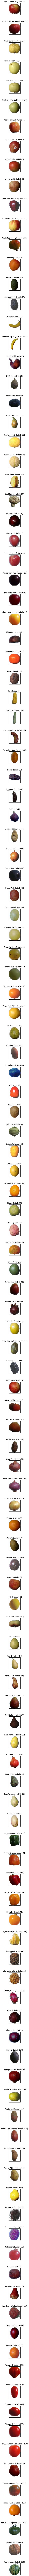

In [7]:
classes_ids = np.unique(train_generator.labels)
f, axes = plt.subplots(len(classes_ids),1, figsize=(2, len(classes_ids)*2))
f.tight_layout()

class_sizes = {'Label':[], 'Name':[], 'Size':[]}

for cidx, class_id in enumerate(classes_ids):
    class_samples_idxs = np.argwhere(train_generator.labels == class_id).ravel()
    image_idx = class_samples_idxs[0]
    image_path = train_generator.filepaths[image_idx]
    
    image_label = os.path.dirname(image_path) # only OK if shuffle=false
    class_name = image_label.split("\\")[-1]
    class_label = train_generator.labels[image_idx]

    class_sizes['Label'].append(class_label)
    class_sizes['Name'].append(class_name)
    class_sizes['Size'].append(len(class_samples_idxs))


    image_obj = mpimg.imread(image_path)
    image_obj = image_obj/255
    image_obj = img_to_array(image_obj)
    ax=axes[cidx]
    ax.imshow(image_obj)
    ax.set_title(f"{class_name} (Label={class_label})")
    ax.set_xticks([])
    ax.set_yticks([])


# Show the number of training samples per class

Text(0.5, 0, 'Class Label')

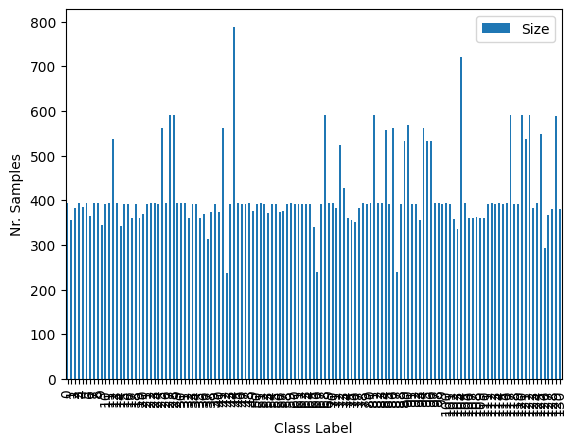

In [8]:
df = pd.DataFrame(class_sizes)
df[['Label', 'Size']].plot.bar(x='Label')
plt.ylabel("Nr. Samples")
plt.xlabel("Class Label")

# Design the CNN Architecture

In [9]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = (img_size, img_size, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 128, activation = 'relu'))

# Output layer must be the same size as number of classes
classifier.add(Dense(units = nr_classes, activation = 'softmax'))

# Compile CNN <br>
Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).

In [10]:
# or sparse_categorical_crossentropy
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                  

# Train the CNN

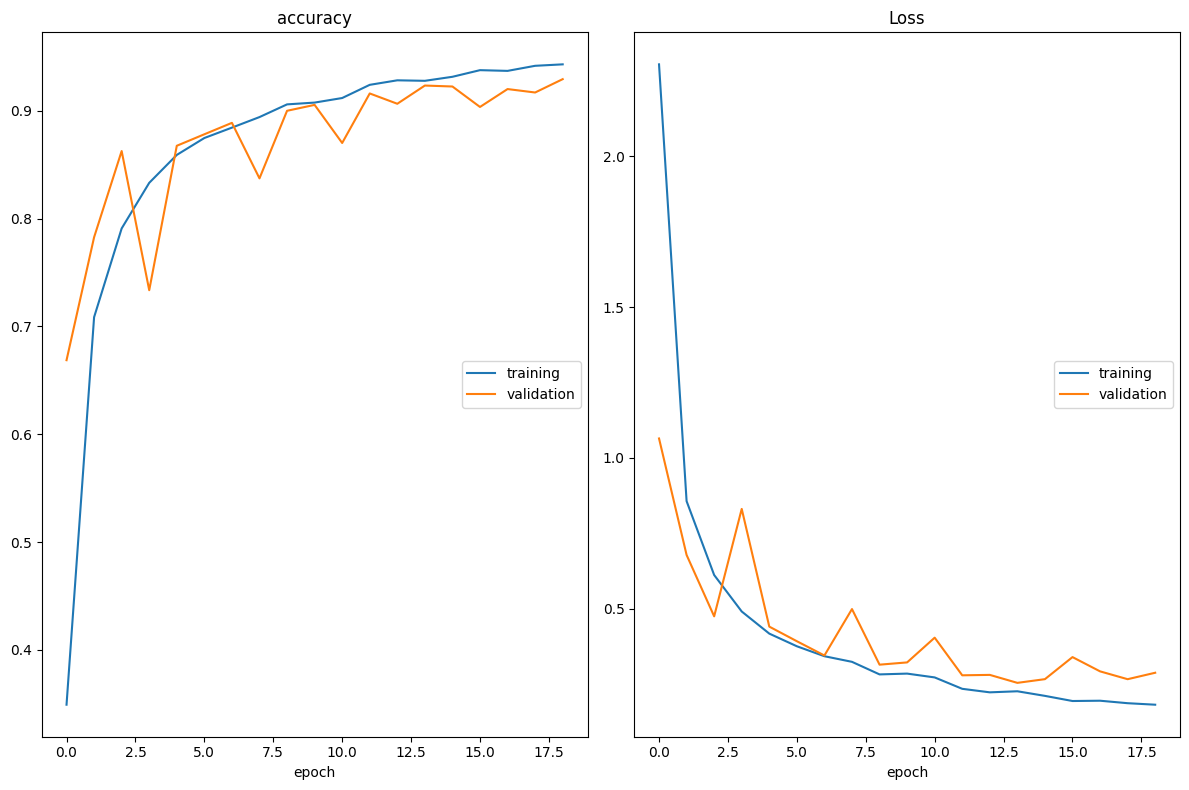

accuracy
	training         	 (min:    0.349, max:    0.943, cur:    0.943)
	validation       	 (min:    0.669, max:    0.929, cur:    0.929)
Loss
	training         	 (min:    0.182, max:    2.305, cur:    0.182)
	validation       	 (min:    0.254, max:    1.064, cur:    0.288)


In [11]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
classifier.fit(train_generator,
               batch_size=64,
               epochs = 100,
               validation_data = validation_generator,
               callbacks=[PlotLossesKeras(), early_stopping],
               verbose=0)

# Test the CNN

In [12]:
y_pred = classifier.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_test = test_generator.labels

709/709 [==============================] - 218s 308ms/step


In [13]:
print(y_pred.shape)
print(y_test.shape)

(22688,)
(22688,)


In [14]:
cm_results = confusion_matrix(y_test.ravel(), y_pred.ravel())
display(cm_results)

array([[102,   0,   0, ...,   0,   0,   0],
       [  0, 114,   0, ...,   0,   0,   0],
       [  0,   0, 160, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 158,   0,   0],
       [  0,   0,   0, ...,   0, 249,   0],
       [  0,   0,   0, ...,   0,   0, 157]], dtype=int64)

# Self calculated accuracy

In [15]:
accuracy_per_class = cm_results.diagonal()/cm_results.sum(axis=1)
avg_accuracy = np.mean(accuracy_per_class)
print(avg_accuracy)

0.9498554350828016


In [16]:
class_sizes['Accuracy'] = accuracy_per_class*100
df = pd.DataFrame(class_sizes)

Text(0.5, 1.0, 'Nr. Samples per class')

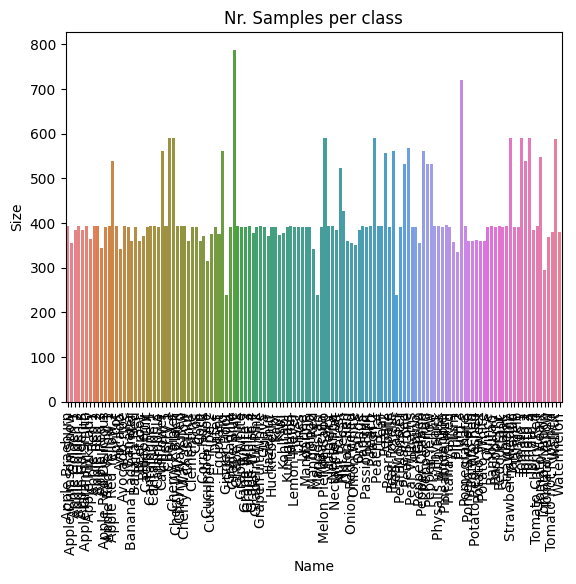

In [17]:
sns.barplot(data=df[['Name', 'Size']], x='Name',y='Size', hue='Name')
plt.xticks(rotation = 90);
plt.title("Nr. Samples per class")

Text(0.5, 1.0, 'Accuracy per class')

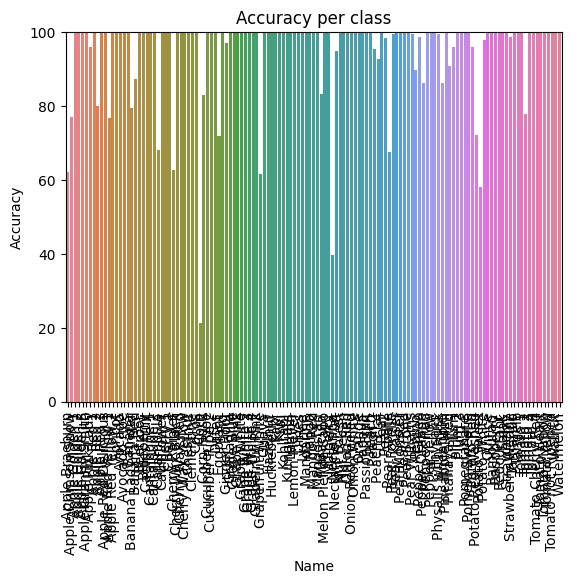

In [18]:
sns.barplot(data=df[['Name', 'Accuracy']], x='Name',y='Accuracy', hue='Name')
plt.xticks(rotation = 90)
plt.ylim([0,100])
plt.title("Accuracy per class")

# Sklearn accuracy

In [19]:
accuracy_score(y_test, y_pred)

0.9512958392101551